In [61]:
import pyvista as pv
import numpy as np
from scipy.interpolate import make_interp_spline
pv.set_jupyter_backend('client')
from generate_noisy_pipe import *

# Noisy cylinder

In [62]:
# Define mesh path
case_path = '/home/dana/Documents/SimVascular/svMultiPhysics/NoisyPipe/tests/NP_Severe/'
mesh_path = case_path + 'mesh/'
geom_path = case_path + 'geom/'

In [63]:
# Define cylinder parameters
h = 10.
radius = 1. # Base inner radius
t = 0.2 # Solid wall thickness

# Define angular resolution
N_ares = 128

# Initialize cross sections
N_base = 32 # Base number of cross sections
N_ref = 200 # Number of refinement points (for spline)

# Define modes
num_modes = 4
kmin = 2
kmax = 8
Amin = -0.1
Amax = 0.1

fluid, solid, combined, region_solid = generate_geometry(radius, h, t, num_modes, kmin, kmax, Amin, Amax, N_ares, N_base, N_ref, random_seed=42)
fluid.save(geom_path + "fluid.vtp")
solid.save(geom_path + "solid.vtp")
combined.save(geom_path + "combined.vtp")


In [64]:
# Load geometry files
fluid = pv.read(geom_path + "fluid.vtp")
solid = pv.read(geom_path + "solid.vtp")
combined = pv.read(geom_path + "combined.vtp")

# Visualize
pl = pv.Plotter()
pl.add_mesh(combined, cmap='tab10')#,show_edges=True)
pl.add_points(region_solid, color='red')
pl.show()
print('Fluid manifold?', fluid.is_manifold)
print('Solid manifold?', solid.is_manifold)

Widget(value='<iframe src="http://localhost:33755/index.html?ui=P_0x75512c42d5e0_30&reconnect=auto" class="pyv…

Fluid manifold? True
Solid manifold? True


In [65]:
# Define region seed points
region_points = [
    ([0, 0, 0], 1),  # inside fluid
    (region_solid, 2),  # inside solid
]

# Generate mesh
mesh, attrib = mesh_geometry(combined,region_points)
meshes = extract_region(mesh,attrib)
fluid_mesh = meshes[0]
solid_mesh = meshes[1]

# Split surfaces
inlet_surf_f, outlet_surf_f, wall_surfs_f = split_surfaces(fluid_mesh)
inlet_surf_s, outlet_surf_s, wall_surfs_s = split_surfaces(solid_mesh)

# Save the volume and surface meshes
fluid_mesh.save(mesh_path + "fluid/mesh-complete.vtu")
inlet_surf_f.extract_surface(pass_cellid=True,pass_pointid=True).save(mesh_path + "fluid/mesh-surfaces/inlet.vtp")
outlet_surf_f.extract_surface(pass_cellid=True,pass_pointid=True).save(mesh_path + "fluid/mesh-surfaces/outlet.vtp")
wall_surfs_f[0].extract_surface(pass_cellid=True,pass_pointid=True).save(mesh_path + "fluid/mesh-surfaces/interface.vtp")
solid_mesh.save(mesh_path + "solid/mesh-complete.vtu")
inlet_surf_s.extract_surface(pass_cellid=True,pass_pointid=True).save(mesh_path + "solid/mesh-surfaces/inlet.vtp")
outlet_surf_s.extract_surface(pass_cellid=True,pass_pointid=True).save(mesh_path + "solid/mesh-surfaces/outlet.vtp")
wall_surfs_s[1].extract_surface(pass_cellid=True,pass_pointid=True).save(mesh_path + "solid/mesh-surfaces/outside.vtp")
wall_surfs_s[0].extract_surface(pass_cellid=True,pass_pointid=True).save(mesh_path + "solid/mesh-surfaces/interface.vtp")
# wall_surfs_f[0].extract_surface(pass_cellid=True,pass_pointid=True).save(mesh_path + "solid/mesh-surfaces/interface.vtp") # Should be the same

Delaunizing vertices...
Delaunay seconds:  0.152466
Creating surface mesh ...
Surface mesh seconds:  0.046816
Recovering boundaries...
Boundary recovery seconds:  0.192348
Removing exterior tetrahedra ...
Spreading region attributes.
Exterior tets removal seconds:  0.064489
Recovering Delaunayness...
Delaunay recovery seconds:  0.078835
Refining mesh...
  68249 insertions, added 44716 points, 1142061 tetrahedra in queue.
Refinement seconds:  1.57451
Smoothing vertices...
Mesh smoothing seconds:  2.41988
Improving mesh...
Mesh improvement seconds:  0.104257

Writing nodes.
Writing elements.
Writing faces.
Writing edges.

Output seconds:  0.059824
Total running seconds:  4.69391

Statistics:

  Input points: 51200
  Input facets: 102652
  Input segments: 150522
  Input holes: 0
  Input regions: 2

  Mesh points: 97964
  Mesh tetrahedra: 530684
  Mesh faces: 1088014
  Mesh faces on exterior boundary: 53292
  Mesh faces on input facets: 104368
  Mesh edges on input segments: 150595
  Stein

In [66]:
# Load fluid
f_vol = pv.read(mesh_path + "fluid/mesh-complete.vtu")
f_inlet = pv.read(mesh_path + "fluid/mesh-surfaces/inlet.vtp")
f_outlet = pv.read(mesh_path + "fluid/mesh-surfaces/outlet.vtp")
f_interface = pv.read(mesh_path + "fluid/mesh-surfaces/interface.vtp")
f_vol_c = f_vol.clip(normal='y',origin=(0,0,0),invert=True)
f_inlet = f_inlet.clip(normal='y',origin=(0,0,0),invert=True)
f_outlet = f_outlet.clip(normal='y',origin=(0,0,0),invert=True)
f_interface = f_interface.clip(normal='y',origin=(0,0,0),invert=True)

# Load solid
s_vol = pv.read(mesh_path + "solid/mesh-complete.vtu")
s_inlet = pv.read(mesh_path + "solid/mesh-surfaces/inlet.vtp")
s_outlet = pv.read(mesh_path + "solid/mesh-surfaces/outlet.vtp")
s_interface = pv.read(mesh_path + "solid/mesh-surfaces/interface.vtp")
s_outside = pv.read(mesh_path + "solid/mesh-surfaces/outside.vtp")
s_vol_c = s_vol.clip(normal='y',origin=(0,0,0),invert=True)
s_inlet = s_inlet.clip(normal='y',origin=(0,0,0),invert=True)
s_outlet = s_outlet.clip(normal='y',origin=(0,0,0),invert=True)
s_interface = s_interface.clip(normal='y',origin=(0,0,0),invert=True)
s_outside = s_outside.clip(normal='y',origin=(0,0,0),invert=True)

# Some camera stuff
cam = [(13,3,3),(3,0,0),(0,0,1)]
cam2 = [(0,25,0),(0,0,0),(0,0,1)]

plotter1 = pv.Plotter(shape=(1,2),off_screen=True)
# Volume mesh
plotter1.subplot(0,0)
plotter1.camera_position = cam
plotter1.add_mesh(f_vol_c, color='cyan', edge_opacity=0.5, show_edges=True) # Fluid
plotter1.add_mesh(s_vol_c, color='magenta', edge_opacity=0.5, show_edges=True) # Solid
plotter1.add_text("Volume Mesh", font_size=12)
plotter1.add_axes()
# Surface meshes
plotter1.subplot(0,1)
plotter1.camera_position = cam
# Fluid
plotter1.add_mesh(f_inlet, color='cyan', opacity=0.5, edge_opacity=0.5, show_edges=True)
plotter1.add_mesh(f_outlet, color='magenta', opacity=0.5, edge_opacity=0.5, show_edges=True)
plotter1.add_mesh(f_interface, color='green', edge_opacity=0.5, show_edges=True)
# Solid
plotter1.add_mesh(s_inlet, color='cyan', edge_opacity=0.5, show_edges=True)
plotter1.add_mesh(s_outlet, color='magenta', edge_opacity=0.5, show_edges=True)
plotter1.add_mesh(s_outside, color='red', edge_opacity=0.5, show_edges=True)
plotter1.add_text("Surface Mesh", font_size=12)
plotter1.add_axes()
plotter1.show()
plotter1.save_graphic('mesh.eps')

plotter2 = pv.Plotter(shape=(1,2))
# Whole geometries
plotter2.subplot(0,0)
plotter2.camera_position = cam2
plotter2.add_mesh(f_vol_c, color='cyan', opacity=0.5, show_edges=False) # Fluid
plotter2.add_mesh(s_vol_c, color='magenta', opacity=0.5, show_edges=False) # Solid
plotter2.add_axes()
plotter2.subplot(0,1)
plotter2.add_mesh(f_vol, color='cyan', opacity=0.5, show_edges=False) # Fluid
plotter2.add_mesh(s_vol, color='magenta', opacity=0.5, show_edges=False) # Solid
plotter2.add_axes()
plotter2.show()
plotter2.save_graphic('geom.eps')

Widget(value='<iframe src="http://localhost:33755/index.html?ui=P_0x755086120fb0_31&reconnect=auto" class="pyv…

Widget(value='<iframe src="http://localhost:33755/index.html?ui=P_0x75512d054c80_32&reconnect=auto" class="pyv…

In [67]:
fluid_mesh

UnstructuredGrid (0x75508614e080)
  N Cells:    211713
  N Points:   47377
  X Bounds:   -5.000e+00, 5.000e+00
  Y Bounds:   -1.238e+00, 1.180e+00
  Z Bounds:   -1.168e+00, 1.167e+00
  N Arrays:   4

Approx. smallest cell length: 0.008771565309665108
Approx. dt for CFL=1: 8.771565309665108e-05


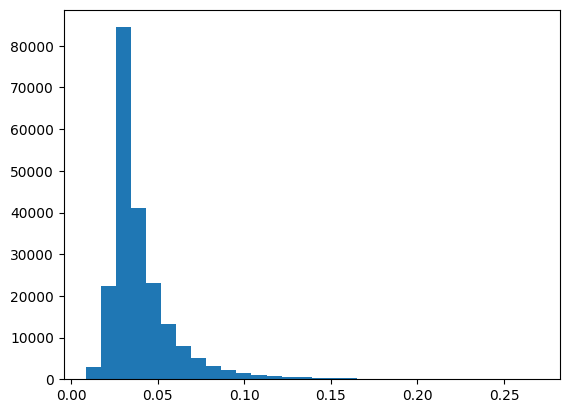

In [68]:
import matplotlib.pyplot as plt 
# plt.hist(fluid_mesh.compute_cell_sizes())
fluid_mesh = fluid_mesh.compute_cell_sizes()
plt.hist(fluid_mesh['Volume']**(1/3), bins=30)#, range=(0, 0.01))
delta_min = np.min(fluid_mesh['Volume'])**(1/3)
print('Approx. smallest cell length: ' + str(delta_min))
print('Approx. dt for CFL=1: ' + str(delta_min/100.)) 

Approx. smallest cell length: 0.008771565309665108
Approx. dt for CFL=1: 8.771565309665108e-05


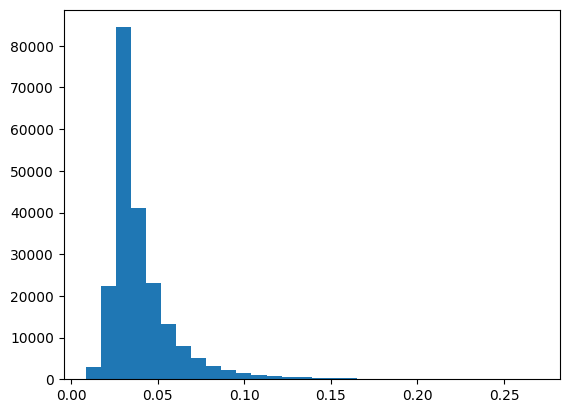

In [ ]:
import matplotlib.pyplot as plt 
# plt.hist(fluid_mesh.compute_cell_sizes())
fluid_mesh = fluid_mesh.compute_cell_sizes()
plt.hist(fluid_mesh['Volume']**(1/3), bins=30)#, range=(0, 0.01))
delta_min = np.min(fluid_mesh['Volume'])**(1/3)
print('Approx. smallest cell length: ' + str(delta_min))
print('Approx. dt for CFL=1: ' + str(delta_min/100.)) 

# TRASH

In [7]:
# Define cylinder parameters
h = 10.
radius = 1. # Base inner radius
t = 0.2 # Solid wall thickness

# Define angular resolution
n = 64
theta = np.linspace(0, 2 * np.pi, n, endpoint=False)

# Initialize cross sections
N = 10 # Base number of cross sections
N_ref = 100 # Number of refinement points (for spline)
points_list = [] # Inner
points_list_o = [] # Outer
dx = h/N

# Define modes
num_modes = 4
kmin = 2
kmax = 8
Amin = 0.
Amax = 0.1

# Random seed
np.random.seed(42)

for i in range(N):
    r = radius
    xloc = dx*i-h/2 # Center cylinder at (0,0,0)

    for j in range(num_modes):
        # Get random number
        k = np.random.randint(kmin,kmax)
        A = np.random.uniform(Amin,Amax)

        # Define radial function r(θ)
        r += A * np.cos(k*theta) # Multimodal noise

    # Convert to Cartesian (x, y)
    y,z = r * np.cos(theta), r * np.sin(theta)
    yo,zo = (r+t) * np.cos(theta), (r+t) * np.sin(theta)

    # x positions for shape
    x = np.full_like(y, xloc)
    xo = np.full_like(yo, xloc)

    # Stack points
    slice_points = np.column_stack([x,y,z])
    slice_points_o = np.column_stack([xo,yo,zo])

    # Add to list
    points_list.append(slice_points)
    points_list_o.append(slice_points_o)
    

# Combine all points
points = np.vstack(points_list)
points_o = np.vstack(points_list_o)

# Create quad faces for the side
faces = []
faces_o = []
for layer in range(N - 1):  # loop over layers
    offset0 = layer * n
    offset1 = (layer + 1) * n
    for i in range(n):
        i0 = offset0 + i
        i1 = offset0 + (i + 1) % n
        j1 = offset1 + (i + 1) % n
        j0 = offset1 + i
        faces.append([4, i0, i1, j1, j0])
        faces_o.append([4, i0, i1, j1, j0])

# Flatten face list
faces = np.hstack(faces)
wall = pv.PolyData(points, faces)
faces_o = np.hstack(faces_o)
wall_o = pv.PolyData(points_o, faces_o)

# Inlet polygon
inlet = pv.Polygon(center=(0,0,-0.5), radius=1.0, n_sides=n)
inlet.points = points_list[0]  
inlet = inlet.triangulate()
inlet_o = pv.Polygon(center=(0,0,-0.5), radius=1.0, n_sides=n)
inlet_o.points = points_list_o[0]  
inlet_o = inlet_o.triangulate()

# Outlet polygon
outlet = pv.Polygon(center=(0,0,0.5), radius=1.0, n_sides=n)
outlet.points = points_list[-1]
outlet = outlet.triangulate()
outlet_o = pv.Polygon(center=(0,0,0.5), radius=1.0, n_sides=n)
outlet_o.points = points_list_o[-1]
outlet_o = outlet_o.triangulate()

# Solid wall inlet/outlet (annuli)
points_solid_inlet = np.vstack([points_list[-1],points_list_o[-1]])
points_solid_outlet = np.vstack([points_list[0],points_list_o[0]])
faces_solid_inlet = []
faces_solid_outlet = []
for i in range(n):
    # Indices
    a0 = i
    a1 = (i + 1) % n
    b0 = i + n
    b1 = ((i + 1) % n) + n

    # Triangles for quad face between (a0, a1, b1, b0)
    faces_solid_inlet.append([3, a0, a1, b1])
    faces_solid_inlet.append([3, a0, b1, b0])
    faces_solid_outlet.append([3, a0, a1, b1])
    faces_solid_outlet.append([3, a0, b1, b0])

faces_solid_inlet = np.array(faces_solid_inlet, dtype=np.int32).flatten()
solid_inlet = pv.PolyData(points_solid_inlet,faces_solid_inlet)
faces_solid_outlet = np.array(faces_solid_outlet, dtype=np.int32).flatten()
solid_outlet = pv.PolyData(points_solid_outlet,faces_solid_outlet)

# Label patches (doesn't do anything for now)
inlet.cell_data['marker']=0
outlet.cell_data['marker']=1
wall.cell_data['marker']=2
wall_o.cell_data['marker']=3
solid_inlet.cell_data['marker']=4
solid_outlet.cell_data['marker']=5

# Merge everything
fluid = wall.merge(inlet).merge(outlet)
solid = wall.merge(solid_inlet).merge(solid_outlet).merge(wall_o)
combined = wall.merge(inlet).merge(outlet).merge(solid_inlet).merge(solid_outlet).merge(wall_o)

In [10]:

# # Loft between contours
# wall = None
# wall_o = pv.PolyData()
# for i in range(len(contours)-1):
#     # # Loft between contours of inner wall
#     # ruled = vtkRuledSurfaceFilter()
#     # ruled.SetInputData(contours[i].merge(contours[i+1]))
#     # ruled.SetRuledModeToResample()
#     # ruled.SetResolution(n, 1)
#     # ruled.Update()
#     # loft = pv.wrap(ruled.GetOutput())
#     # if wall is None:
#     #     wall = loft.copy()
#     # else:
#     #     wall = wall.merge(loft)

#     # Loft between contours of outer wall
#     ruled = vtkRuledSurfaceFilter()
#     ruled.SetInputData(contours_o[i].merge(contours_o[i+1]))
#     ruled.SetRuledModeToResample()
#     ruled.SetResolution(n, 1)
#     ruled.Update()
#     loft = pv.wrap(ruled.GetOutput())
#     wall_o = wall_o.merge(loft)

# # Loft between contours of inner wall
# ruled = vtkRuledSurfaceFilter()
# ruled.SetInputData(contours_combined)
# ruled.SetRuledModeToResample()
# ruled.SetResolution(n, 1)
# ruled.Update()
# wall = pv.wrap(ruled.GetOutput())